In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from textwrap import wrap
import os

def compute_pmi(binary_data):
    """
    Compute the Pointwise Mutual Information (PMI) matrix from binary data.
    
    Parameters:
    - binary_data: DataFrame where each cell indicates the presence (1) or absence (0) of a label.
    
    Returns:
    - PMI matrix as a DataFrame.
    """
    # Total number of samples
    total_samples = binary_data.shape[0]
    
    # Co-occurrence matrix calculation
    co_occurrence_matrix = np.dot(binary_data.T, binary_data).astype(float)
    
    # Probabilities of each label
    label_probabilities = binary_data.sum(axis=0) / total_samples
    
    # Joint probabilities for each label pair
    joint_probabilities = co_occurrence_matrix / total_samples
    
    # Compute PMI for each label pair
    with np.errstate(divide='ignore', invalid='ignore'):
        pmi_matrix = np.log(joint_probabilities / np.outer(label_probabilities, label_probabilities))
        pmi_matrix = np.where(np.isinf(pmi_matrix), 0, pmi_matrix)  # Replace infinities with zeros
    
    # Convert PMI matrix to DataFrame for better readability
    pmi_df = pd.DataFrame(pmi_matrix, index=binary_data.columns, columns=binary_data.columns)
    return pmi_df

def classify_pmi_values(pmi_df):
    """
    Classify PMI values into 'Weak', 'Moderate', and 'Strong' associations based on quantiles.
    
    Parameters:
    - pmi_df: DataFrame containing PMI values.
    
    Returns:
    - DataFrame with association labels.
    """
    positive_pmis = pmi_df[pmi_df > 0].stack().values
    weak_threshold = np.percentile(positive_pmis, 25)
    strong_threshold = np.percentile(positive_pmis, 75)
    
    def classify(value):
        if value > 0:
            if value < weak_threshold:
                return 'Weak association'
            elif value < strong_threshold:
                return 'Moderate association'
            else:
                return 'Strong association'
        return 'No association'
    
    classified_pmi_df = pmi_df.applymap(classify)
    return classified_pmi_df




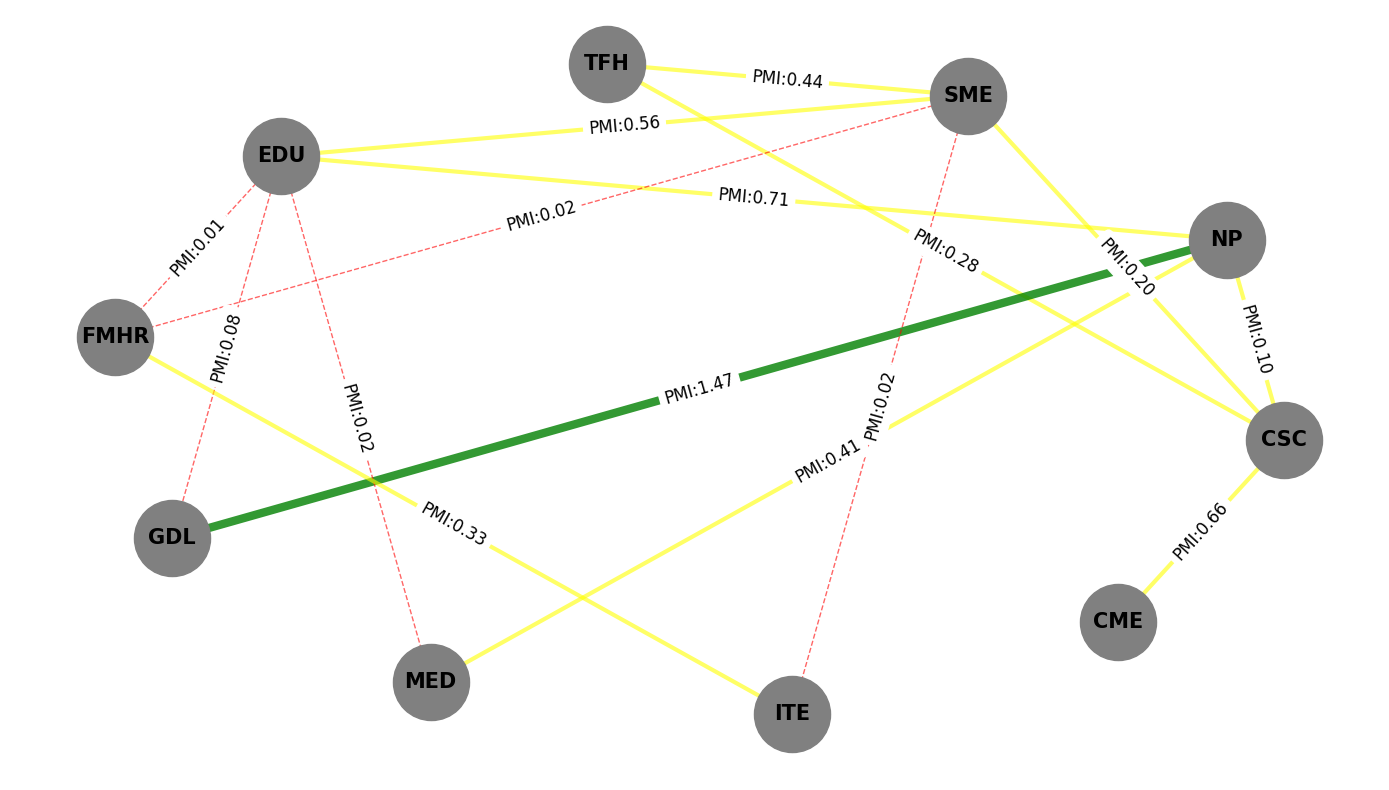

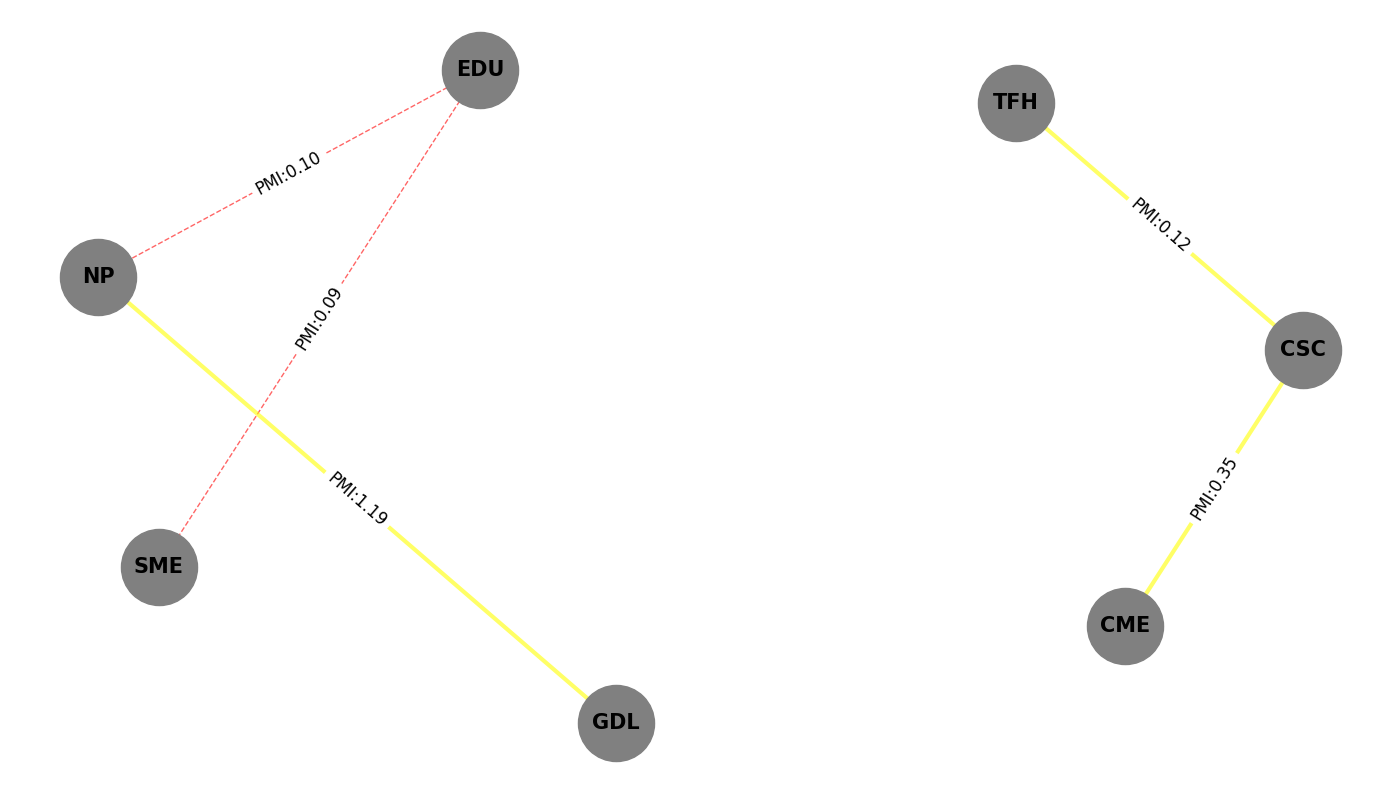

In [2]:
import pandas as pd
import os
#  Define the label names and their corresponding acronyms
label_names = ['Civil, Mechanical & Electrical', 'Consumer & Supply Chain',
               'Education', 'Finance, Marketing & Human Resources',
               'Government, Defense & Legal', 'Information Technology & Electronics',
               'Medical', 'Non-profit', 'Sports, Media & Entertainment',
               'Travel, Food & Hospitality']

label_acronyms = ['CME', 'CSC', 'EDU', 'FMHR', 'GDL', 'ITE', 'MED', 'NP', 'SME', 'TFH']


output_dir = '/data/sxs7285/Porjects_code/sector_activity/SPL_classification/results/'
data_1 = pd.read_csv(os.path.join(output_dir, 'loss_wan0.1_roberta/probs_val.csv'), header=None)



output_dir = '/data/sxs7285/Porjects_code/sector_activity/SPL_classification/results/'
data_2 = pd.read_csv(os.path.join(output_dir, 'loss_wan0.3_roberta/probs_val.csv'), header=None)
# Assign acronyms as column names for both datasets
data_1.columns = label_acronyms
data_2.columns = label_acronyms

# Convert probabilities to binary labels using a 0.5 threshold for both datasets
binary_data_1 = (data_1 > 0.5).astype(int)
binary_data_2 = (data_2 > 0.5).astype(int)

# Compute the PMI matrix for both datasets
pmi_df_1 = compute_pmi(binary_data_1)
pmi_df_2 = compute_pmi(binary_data_2)

# Classify the PMI values for both datasets
classified_pmi_df_1 = classify_pmi_values(pmi_df_1)
classified_pmi_df_2 = classify_pmi_values(pmi_df_2)

# Modify the graph creation function to remove nodes without edges
def create_sparse_pmi_graph(pmi_df, classified_pmi_df, threshold=0):
    """
    Create a sparse PMI graph where nodes with no edges are removed.
    
    Parameters:
    - pmi_df: DataFrame containing PMI values.
    - classified_pmi_df: DataFrame containing PMI classifications.
    - threshold: Minimum PMI value for an edge to be included in the graph.
    
    Returns:
    - The generated graph.
    """
    G = nx.Graph()
    
    # Add edges with PMI values above the threshold
    for i in range(len(pmi_df)):
        for j in range(i+1, len(pmi_df)):
            pmi_value = pmi_df.iloc[i, j]
            if pmi_value > threshold:
                classification = classified_pmi_df.iloc[i, j]
                G.add_edge(pmi_df.index[i], pmi_df.columns[j], weight=pmi_value, classification=classification)
    
    # Remove nodes with no edges
    G.remove_nodes_from(list(nx.isolates(G)))
    
    # Draw the graph
    # pos = nx.random_layout(G,center=(1, 0) )
    pos = nx.shell_layout(G,rotate = -np.pi/4,center=(0, 3))
    # pos = nx.planar_layout(G)
    # pos = nx.circular_layout(G)  # Circular layout for better visualization

    plt.figure(figsize=(14,8))
    plt.gca().set_facecolor('lightgrey')
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="grey", alpha=1.0)
    
    # Draw edges with different styles based on classification
    for (u, v, d) in G.edges(data=True):
        if d['classification'] == 'Strong association':
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=6, edge_color='green', alpha=0.8)
        elif d['classification'] == 'Moderate association':
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=3, edge_color='yellow', alpha=0.6)
        elif d['classification'] == 'Weak association':
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=1, edge_color='red', style='dashed', alpha=0.6)
    
    # Draw edge labels with PMI values and classifications
    # edge_labels = {(u, v): f"{d['weight']:.2f} ({d['classification']})" for u, v, d in G.edges(data=True)}
    edge_labels = {(u, v): "PMI:"+ f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=15, font_weight='bold')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return G

# Display sparse graphs for both datasets with PMI threshold of 0
graph_1 = create_sparse_pmi_graph(pmi_df_1, classified_pmi_df_1, threshold=0)
graph_2 = create_sparse_pmi_graph(pmi_df_2, classified_pmi_df_2, threshold=0)


In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from textwrap import wrap
import os

def compute_pmi(binary_data):
    """
    Compute the Pointwise Mutual Information (PMI) matrix from binary data.
    
    Parameters:
    - binary_data: DataFrame where each cell indicates the presence (1) or absence (0) of a label.
    
    Returns:
    - PMI matrix as a DataFrame.
    """
    # Total number of samples
    total_samples = binary_data.shape[0]
    
    # Co-occurrence matrix calculation
    co_occurrence_matrix = np.dot(binary_data.T, binary_data).astype(float)
    
    # Probabilities of each label
    label_probabilities = binary_data.sum(axis=0) / total_samples
    
    # Joint probabilities for each label pair
    joint_probabilities = co_occurrence_matrix / total_samples
    
    # Compute PMI for each label pair
    with np.errstate(divide='ignore', invalid='ignore'):
        pmi_matrix = np.log(joint_probabilities / np.outer(label_probabilities, label_probabilities))
        pmi_matrix = np.where(np.isinf(pmi_matrix), 0, pmi_matrix)  # Replace infinities with zeros
    
    # Convert PMI matrix to DataFrame for better readability
    pmi_df = pd.DataFrame(pmi_matrix, index=binary_data.columns, columns=binary_data.columns)
    return pmi_df

def classify_pmi_values(pmi_df):
    """
    Classify PMI values into 'Weak', 'Moderate', and 'Strong' associations based on quantiles.
    
    Parameters:
    - pmi_df: DataFrame containing PMI values.
    
    Returns:
    - DataFrame with association labels.
    """
    positive_pmis = pmi_df[pmi_df > 0].stack().values
    weak_threshold = np.percentile(positive_pmis, 25)
    strong_threshold = np.percentile(positive_pmis, 75)
    
    def classify(value):
        if value > 0:
            if value < weak_threshold:
                return 'Weak association'
            elif value < strong_threshold:
                return 'Moderate association'
            else:
                return 'Strong association'
        return 'No association'
    
    classified_pmi_df = pmi_df.applymap(classify)
    return classified_pmi_df




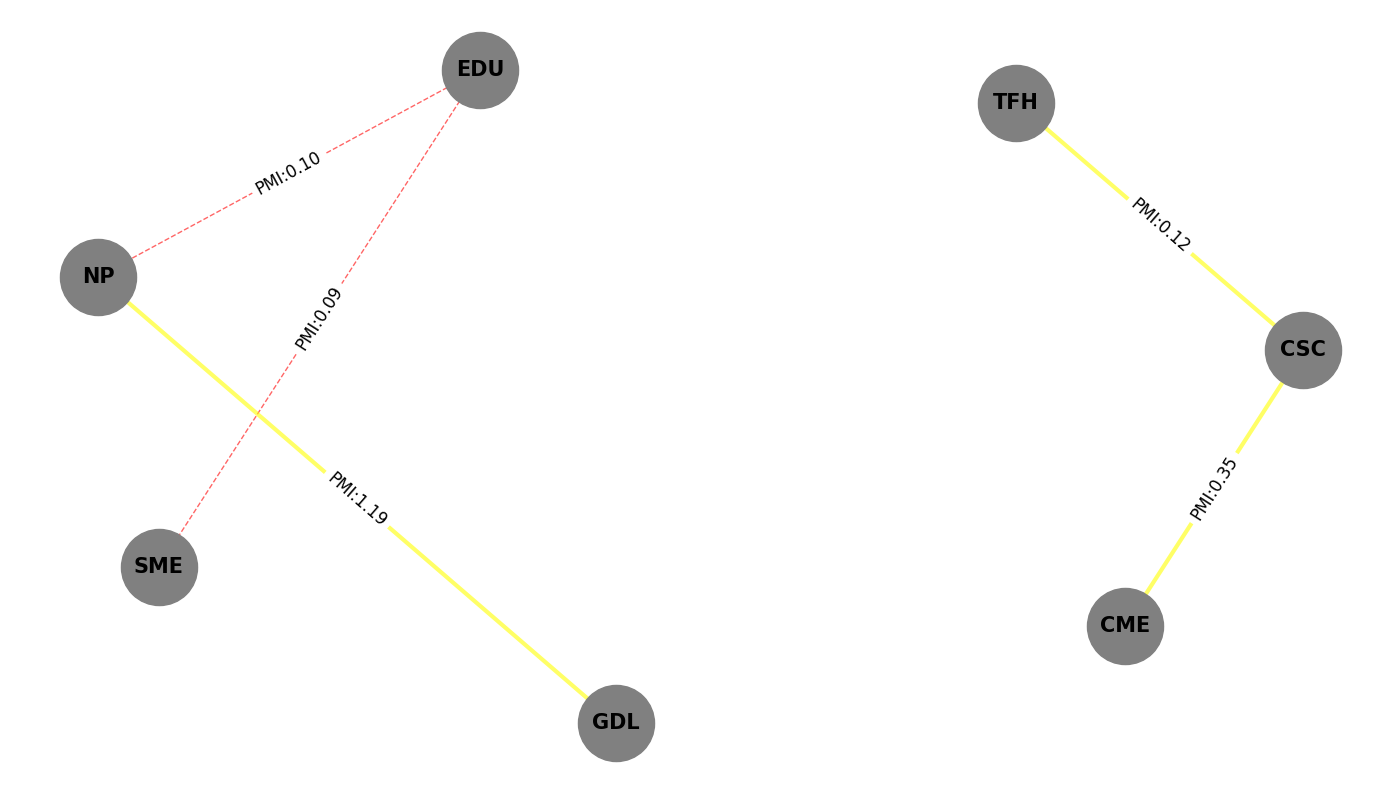

,Label 1,Label 2,PMI Value,Classification
0,GDL,NP,1.190842,Moderate association
1,CME,CSC,0.350224,Moderate association
2,CSC,TFH,0.119366,Moderate association
3,EDU,NP,0.103224,Weak association
4,EDU,SME,0.092129,Weak association
5,GDL,TFH,0.000000,No association
6,MED,NP,-0.063114,No association
7,SME,TFH,-0.100559,No association
8,FMHR,ITE,-0.122042,No association
9,CSC,SME,-0.213570,No association


In [5]:
def create_sorted_pmi_pairs_dataframe(pmi_df, classified_pmi_df):
    """
    Create a DataFrame with label pairs, their PMI values, and their classifications,
    sorted by PMI values in descending order.

    Parameters:
    - pmi_df: DataFrame containing PMI values.
    - classified_pmi_df: DataFrame containing PMI classifications.
    
    Returns:
    - DataFrame with columns: 'Label 1', 'Label 2', 'PMI Value', 'Classification', sorted by PMI values.
    """
    pairs = []
    
    for i in range(len(pmi_df)):
        for j in range(i + 1, len(pmi_df)):
            label_1 = pmi_df.index[i]
            label_2 = pmi_df.columns[j]
            pmi_value = pmi_df.iloc[i, j]
            classification = classified_pmi_df.iloc[i, j]
            pairs.append([label_1, label_2, pmi_value, classification])
    
    # Create DataFrame from the list of pairs
    pairs_df = pd.DataFrame(pairs, columns=['Label 1', 'Label 2', 'PMI Value', 'Classification'])
    
    # Sort by PMI value in descending order
    sorted_pairs_df = pairs_df.sort_values(by='PMI Value', ascending=False).reset_index(drop=True)
    
    return sorted_pairs_df

# Apply the function to your PMI and classification data

graph_2 = create_sparse_pmi_graph(pmi_df_2, classified_pmi_df_2, threshold=0)

sorted_pairs_df_conservative= create_sorted_pmi_pairs_dataframe(pmi_df_2, classified_pmi_df_2)
sorted_pairs_df_conservative


In [7]:
sorted_pairs_df_conservative.to_csv("explanability_conservative.csv", index=False)

In [6]:
sorted_pairs_df_flexible= create_sorted_pmi_pairs_dataframe(pmi_df_1, classified_pmi_df_1)
sorted_pairs_df_flexible

,Label 1,Label 2,PMI Value,Classification
0,GDL,NP,1.469013,Strong association
1,EDU,NP,0.713834,Moderate association
2,CME,CSC,0.659009,Moderate association
3,EDU,SME,0.559823,Moderate association
4,SME,TFH,0.441401,Moderate association
5,MED,NP,0.413225,Moderate association
6,FMHR,ITE,0.334535,Moderate association
7,CSC,TFH,0.277533,Moderate association
8,CSC,SME,0.196295,Moderate association
9,CSC,NP,0.098665,Moderate association


In [8]:
sorted_pairs_df_flexible.to_csv("explanability_flexible.csv", index=False)

In [11]:
import pandas as pd
import json

# Load the dataset
file_path = '/data/sxs7285/Porjects_code/sector_activity/SPL_classification/explanability_flexible.csv'
df = pd.read_csv(file_path)

# Real label names and their acronyms
label_names = ['Civil, Mechanical & Electrical', 'Consumer & Supply Chain',
               'Education', 'Finance, Marketing & Human Resources',
               'Government, Defense & Legal', 'Information Technology & Electronics',
               'Medical', 'Non-profit', 'Sports, Media & Entertainment',
               'Travel, Food & Hospitality']

label_acronyms = ['CME', 'CSC', 'EDU', 'FMHR', 'GDL', 'ITE', 'MED', 'NP', 'SME', 'TFH']

# Create a mapping from acronyms to full label names
label_mapping = dict(zip(label_acronyms, label_names))

# Create the knowledge base dictionary using real names
knowledge_base = {}

# Iterate through the dataframe and fill the dictionary
for index, row in df.iterrows():
    true_label_acronym = row['Label 1']
    predicted_label_acronym = row['Label 2']
    
    # Convert acronyms to real label names
    true_label = label_mapping.get(true_label_acronym, true_label_acronym)
    predicted_label = label_mapping.get(predicted_label_acronym, predicted_label_acronym)
    
    # Create a unique key for each pair of true and predicted label
    key = f"{true_label}__{predicted_label}"
    
    # Gather the explainability information
    explanation_info = {
        'PMI Value': row['PMI Value'],
        'Classification': row['Classification']
    }
    
    # Add to the knowledge base
    knowledge_base[key] = explanation_info

# Save the knowledge base as a JSON file using the real names
knowledge_base_json_path = '/data/sxs7285/Porjects_code/sector_activity/SPL_classification/knowledge_base_flexible.json'
with open(knowledge_base_json_path, 'w') as json_file:
    json.dump(knowledge_base, json_file, indent=4)



In [12]:
import pandas as pd
import json

# Load the dataset
file_path = '/data/sxs7285/Porjects_code/sector_activity/SPL_classification/explanability_conservative.csv'
df = pd.read_csv(file_path)

# Real label names and their acronyms
label_names = ['Civil, Mechanical & Electrical', 'Consumer & Supply Chain',
               'Education', 'Finance, Marketing & Human Resources',
               'Government, Defense & Legal', 'Information Technology & Electronics',
               'Medical', 'Non-profit', 'Sports, Media & Entertainment',
               'Travel, Food & Hospitality']

label_acronyms = ['CME', 'CSC', 'EDU', 'FMHR', 'GDL', 'ITE', 'MED', 'NP', 'SME', 'TFH']

# Create a mapping from acronyms to full label names
label_mapping = dict(zip(label_acronyms, label_names))

# Create the knowledge base dictionary using real names
knowledge_base = {}

# Iterate through the dataframe and fill the dictionary
for index, row in df.iterrows():
    true_label_acronym = row['Label 1']
    predicted_label_acronym = row['Label 2']
    
    # Convert acronyms to real label names
    true_label = label_mapping.get(true_label_acronym, true_label_acronym)
    predicted_label = label_mapping.get(predicted_label_acronym, predicted_label_acronym)
    
    # Create a unique key for each pair of true and predicted label
    key = f"{true_label}__{predicted_label}"
    
    # Gather the explainability information
    explanation_info = {
        'PMI Value': row['PMI Value'],
        'Classification': row['Classification']
    }
    
    # Add to the knowledge base
    knowledge_base[key] = explanation_info

# Save the knowledge base as a JSON file using the real names
knowledge_base_json_path = '/data/sxs7285/Porjects_code/sector_activity/SPL_classification/knowledge_base_conservative.json'
with open(knowledge_base_json_path, 'w') as json_file:
    json.dump(knowledge_base, json_file, indent=4)

